In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from glob import glob
from sklearn.model_selection import train_test_split

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
batch_size = 32

img_height = 128
img_width = 128
img_channels = 3

path_to_train = 'comp-540-spring-2019/train'

glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)

In [5]:
def get_img_id(img_path):
    
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

def image_gen(img_paths, img_size=(img_height, img_width)):

    for img_path in img_paths:
        
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        img = imread(img_path) / 255.
        mask = rgb2gray(imread(mask_path))
        
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        mask = (mask >= 0.5).astype(float)
        
        yield img, mask

/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


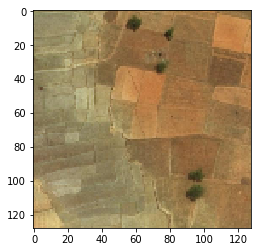

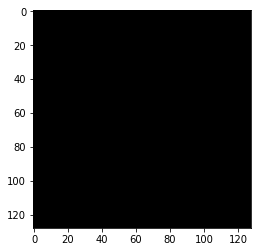

In [6]:
ig = image_gen(train_img_paths)

first_img, first_mask = next(ig)

plt.imshow(first_img)
plt.show()
plt.imshow(first_mask, cmap='gray')
plt.show()

In [7]:
smooth = 1e-9

def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return score

In [6]:
inputs = Input((img_height, img_width, img_channels))
s = Lambda(lambda x: x / 255) (inputs)
n = 1 # can use this as a performance complexity lever
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
def image_batch_generator(img_paths, batchsize=batch_size):
    
    while True:
        
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:

            batch_img.append(img)
            batch_mask.append(mask)

            if len(batch_img) == batchsize:
                
                yield np.stack(batch_img, axis=0), np.expand_dims(np.stack(batch_mask, axis=0),axis = -1)
                batch_img, batch_mask = [], []
        
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.expand_dims(np.stack(batch_mask, axis=0),axis = -1)
            batch_img, batch_mask = [], []

In [8]:
traingen = image_batch_generator(train_img_paths, batchsize=batch_size)

image, mask = next(traingen)
print(image.shape)
print(mask.shape)

(32, 128, 128, 3)
(32, 128, 128, 1)


In [9]:
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.3)

traingen = image_batch_generator(train_img_paths, batchsize=batch_size)
valgen = image_batch_generator(val_img_paths, batchsize=batch_size)

def calc_steps(data_len, batchsize):
    
    return (data_len + batchsize - 1) // batchsize

train_steps = calc_steps(len(train_img_paths), batch_size)
val_steps = calc_steps(len(val_img_paths), batch_size)

# history = model.fit_generator(
#     traingen, 
#     steps_per_epoch=train_steps, 
#     epochs=2, # Change this to a larger number to train for longer
#     validation_data=valgen, 
#     validation_steps=val_steps, 
#     verbose=1,
#     max_queue_size=5  # Change this number based on memory restrictions
# )

# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
#                     callbacks=[earlystopper, checkpointer])

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-comp540-project.h5', verbose=1, save_best_only=True)

results = model.fit_generator(
    
    generator=traingen,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=valgen,
    validation_steps=val_steps,
    verbose=1,
    callbacks=[earlystopper, checkpointer]
    
)

Epoch 1/50
238/239 [============================>.] - ETA: 5s - loss: 0.1740 - dice_coef: 0.0013 

KeyboardInterrupt: 

In [9]:
import keras.losses

keras.losses.loss = dice_coef

In [10]:
best = load_model("model-comp540-project.h5", custom_objects = {'dice_coef':dice_coef})

In [11]:
def test_image_gen(img_paths, img_size=(img_height, img_width)):

    for img_path in img_paths:
        
        img_id = get_img_id(img_path)
        
        img = imread(img_path) / 255.
        
        img = resize(img, img_size, preserve_range=True)
        
        yield img

def test_generator(img_paths, batchsize = batch_size):
    
    while True:
        
        ig = test_image_gen(img_paths)
        batch_img = []
        
        for img in ig:

            batch_img.append(img)

            if len(batch_img) == batchsize:
                
                yield np.stack(batch_img, axis=0)
                batch_img = []
        
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0)
            batch_img = []

In [20]:

img_height = 512
img_width = 512
img_channels = 3

path_to_test = 'comp-540-spring-2019/val'

glob_test_imgs = os.path.join(path_to_test, '*_sat.jpg')

test_img_paths = glob(glob_test_imgs)

batch_size = len(test_img_paths)
batch_size = 10

testgen = test_generator(test_img_paths, batchsize = batch_size)

predictions = best.predict_generator(testgen, 5)

In [15]:
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediciton of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    sub.to_csv(csv_name, index=False)

In [21]:
np.round(predictions).shape

(50, 128, 128, 1)